In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import make_interp_spline
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
roc_curve, auc, confusion_matrix, classification_report, brier_score_loss)
import xgboost as xgb
from sklearn.utils import resample
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import mode
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler
import joblib
import os
import sys
import shutil
from sklearn.exceptions import NotFittedError
from sklearn.utils.validation import check_is_fitted
import seaborn as sns
from collections import defaultdict
from sklearn.ensemble import VotingClassifier

In [2]:
# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
from utilities import bs_calibrate, bs_results, utils

# DATA PREPRATION

In [4]:
df = pd.read_csv("/Users/chufal/projects/DIBHproject/dibh_clinical_only/original_training_data.csv")
data_day1 = df[df['day'] == 1]
X = data_day1.drop(['crnumber', 'day', 'DIBH_Y0N1'], axis=1)
y = data_day1['DIBH_Y0N1']
X_t, X_v, y_t, y_v = train_test_split(X, y, test_size=0.30, random_state=42)

df_internal_val = pd.read_csv("/Users/chufal/projects/DIBHproject/dibh_clinical_only/final_internal_validation13052024.csv")
data_day1_val = df_internal_val[df_internal_val['day'] == 1]
X_int_val = data_day1_val.drop(['crnumber', 'day', 'DIBH_Y0N1'], axis=1)
y_int_val = data_day1_val['DIBH_Y0N1']

categorical_features = ['al_N0_Y1', 'surgery_BCS1MRM2', 'chemo_No0_Adj1_NAdj2', 'comorb_no0_cardio1_others2']
continuous_features = ['age', 'BMI', 'ul_amp', 'll_amp', 'average_amp', 'ahd']

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, continuous_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

# HYPERPARAMETER OPTIMIZATION

In [5]:
# # HYPERPARAMETER OPTIMIZATION
# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 50, 300),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'gamma': trial.suggest_float('gamma', 0.0, 5.0),
#         'lambda': trial.suggest_float('lambda', 0.0, 5.0),
#         'alpha': trial.suggest_float('alpha', 0.0, 5.0)
#     }
#     xgb_clf = make_pipeline(preprocessor, xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss'))
#     cv_roc_auc = cross_val_score(xgb_clf, X_t, y_t, cv=10, scoring='roc_auc').mean()
#     return cv_roc_auc

In [6]:
storage_name = "sqlite:///db.sqlite3_xgb"
# sampler = TPESampler(seed=72)
# # Random seeds - 42,50,58,66,72
# study = optuna.create_study(direction='maximize', sampler=sampler, storage=storage_name, study_name="XGB_one_day_assessment_final04")
# study.optimize(objective, n_trials=1000)

In [7]:
storage_name = "sqlite:///db.sqlite3_xgb"
loaded_study = optuna.create_study(study_name="XGB_one_day_assessment_final04", storage=storage_name, load_if_exists=True)
best_params = loaded_study.best_params

[I 2024-08-06 13:44:12,529] Using an existing study with name 'XGB_one_day_assessment_final04' instead of creating a new one.


## Bootstraping and Calibration

In [8]:
# For Gradient Boosting
top_models_xgb, results_xgb, calibration_data_xgb = bs_calibrate.new_bootstrap_model_evaluation(
    X_t, y_t, X_v, y_v, preprocessor, xgb.XGBClassifier, best_params
)

Bootstrap sample no. 25 ------ Finished
Bootstrap sample no. 50 ------ Finished
Bootstrap sample no. 75 ------ Finished
Bootstrap sample no. 100 ------ Finished
Bootstrap sample no. 125 ------ Finished
Bootstrap sample no. 150 ------ Finished
Bootstrap sample no. 175 ------ Finished
Bootstrap sample no. 200 ------ Finished
Bootstrap sample no. 225 ------ Finished
Bootstrap sample no. 250 ------ Finished
Bootstrap sample no. 275 ------ Finished
Bootstrap sample no. 300 ------ Finished
Bootstrap sample no. 325 ------ Finished
Bootstrap sample no. 350 ------ Finished
Bootstrap sample no. 375 ------ Finished
Bootstrap sample no. 400 ------ Finished
Bootstrap sample no. 425 ------ Finished
Bootstrap sample no. 450 ------ Finished
Bootstrap sample no. 475 ------ Finished
Bootstrap sample no. 500 ------ Finished
Bootstrap sample no. 525 ------ Finished
Bootstrap sample no. 550 ------ Finished
Bootstrap sample no. 575 ------ Finished
Bootstrap sample no. 600 ------ Finished
Bootstrap sample no

## Saving Data 

In [9]:
joblib.dump(top_models_xgb, 'results/bs_training_data/python_objects/top_models_xgb.joblib')
joblib.dump(results_xgb, 'results/bs_training_data/python_objects/results_xgb.joblib')
joblib.dump(calibration_data_xgb, 'results/bs_training_data/python_objects/calibration_data_xgb.joblib')

['results/bs_training_data/python_objects/calibration_data_xgb.joblib']

## Plotting and calibration curves

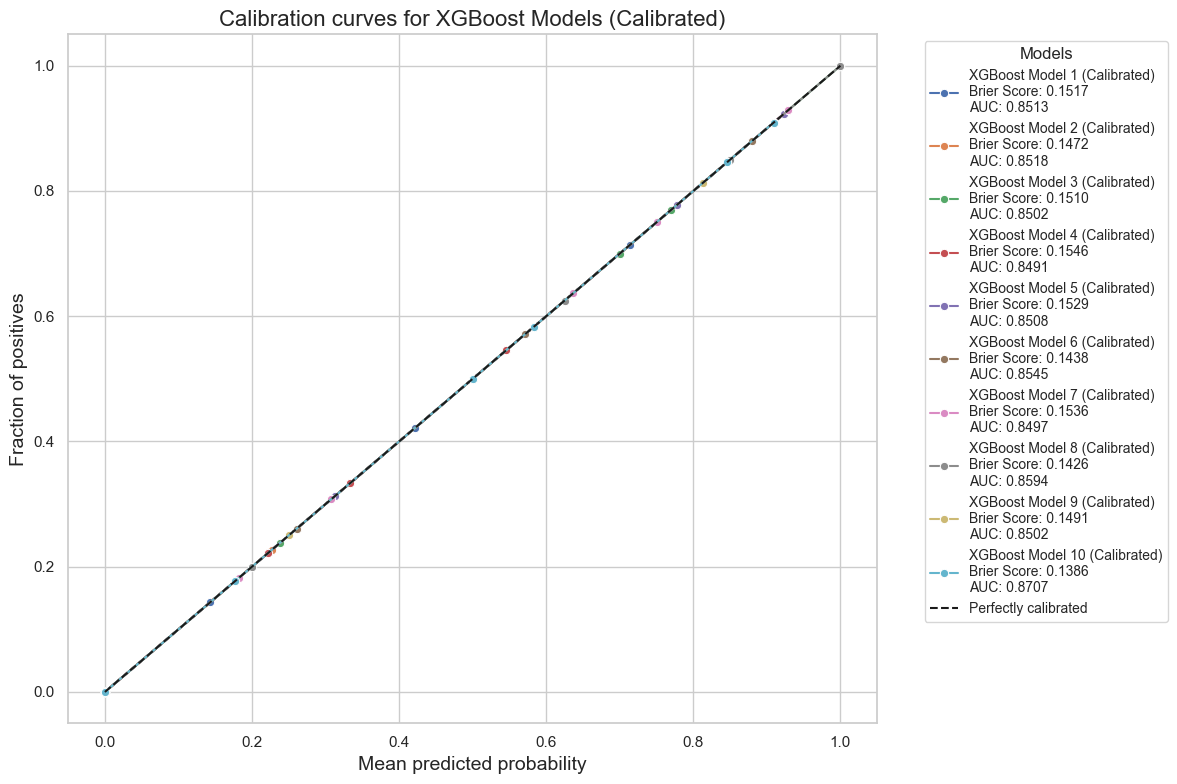

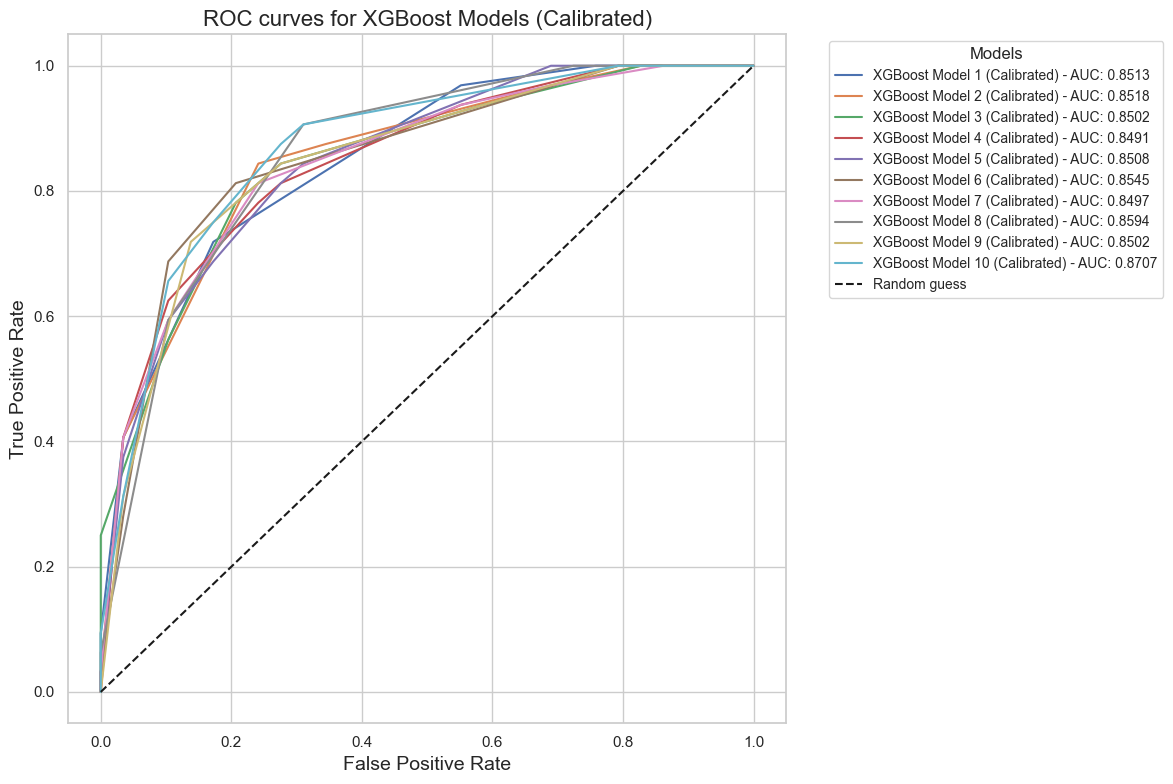

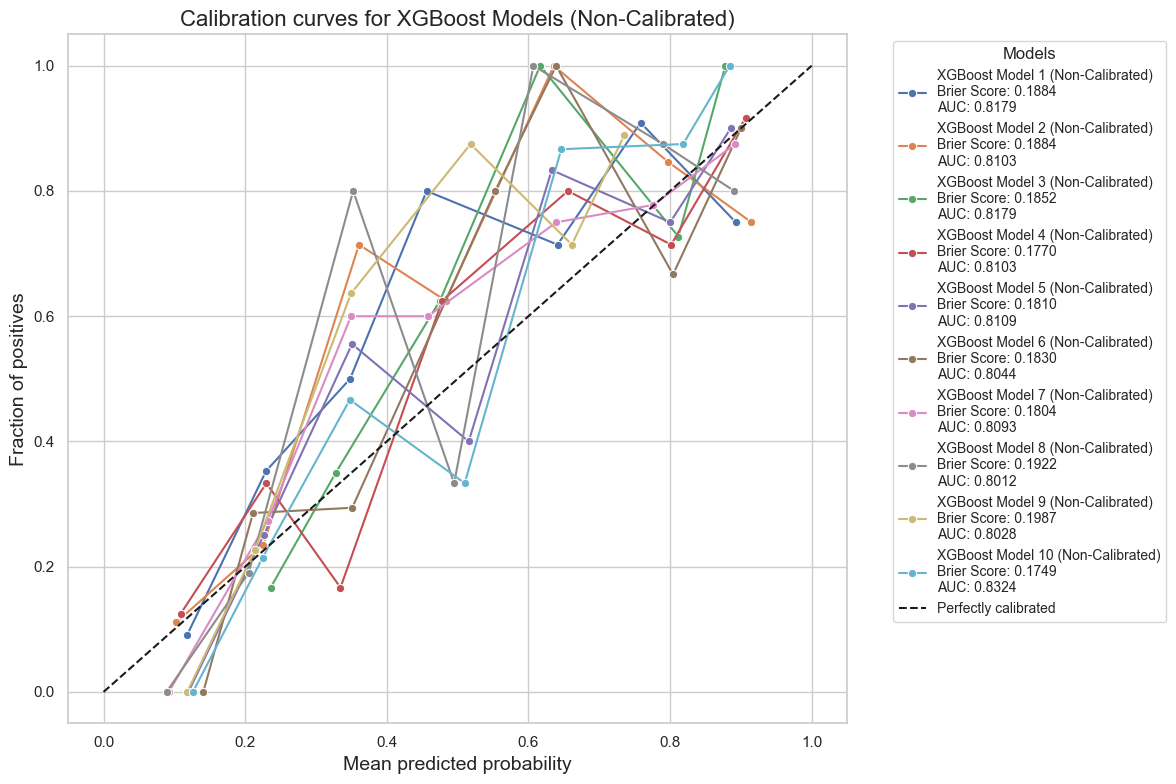

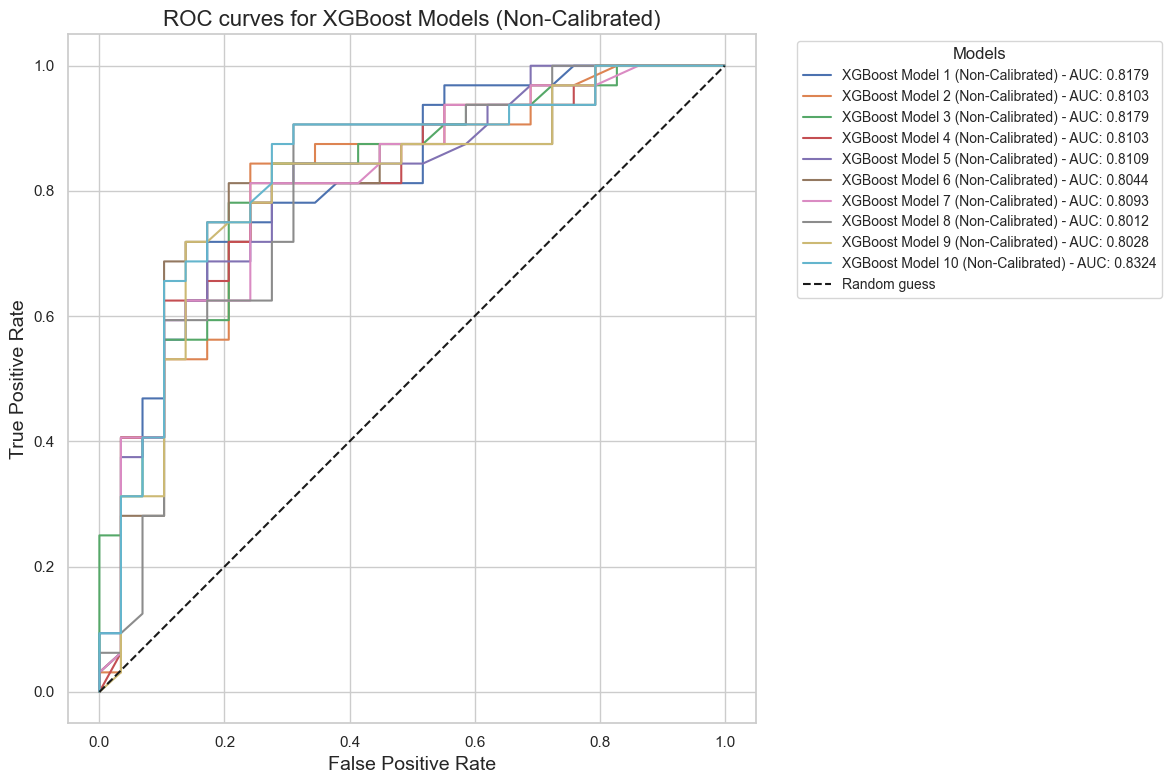

In [10]:
# Assuming calibration_data_gb and calibration_data_cat have the top 10 predicted probabilities
# for Gradient Boosting models
loaded_calibration_data = joblib.load('results/bs_training_data/python_objects/calibration_data_xgb.joblib')
# Example: Plotting calibration curves for top 10 Gradient Boosting models
utils.plot_individual_calibration_curves(y_v, loaded_calibration_data['top_predicted_proba_calibrated'], n_bins=7, model_label="XGBoost", calibrated=True)
utils.plot_individual_calibration_curves(y_v, loaded_calibration_data['top_predicted_proba_non_calibrated'], n_bins=7, model_label="XGBoost", calibrated=False)



## Extract feature importances and save them in a csv file

In [11]:
# Save to CSV
df_importances = utils.save_feature_importances_to_csv(filename='results/bs_training_data/csv/feature_importances_xgb.csv', 
                                                       model_name_prefix='xgb', 
                                                       top_models_path='results/bs_training_data/python_objects/top_models_xgb.joblib')

Data saved to - results/bs_training_data/csv/feature_importances_xgb.csv


## Plot feature importance

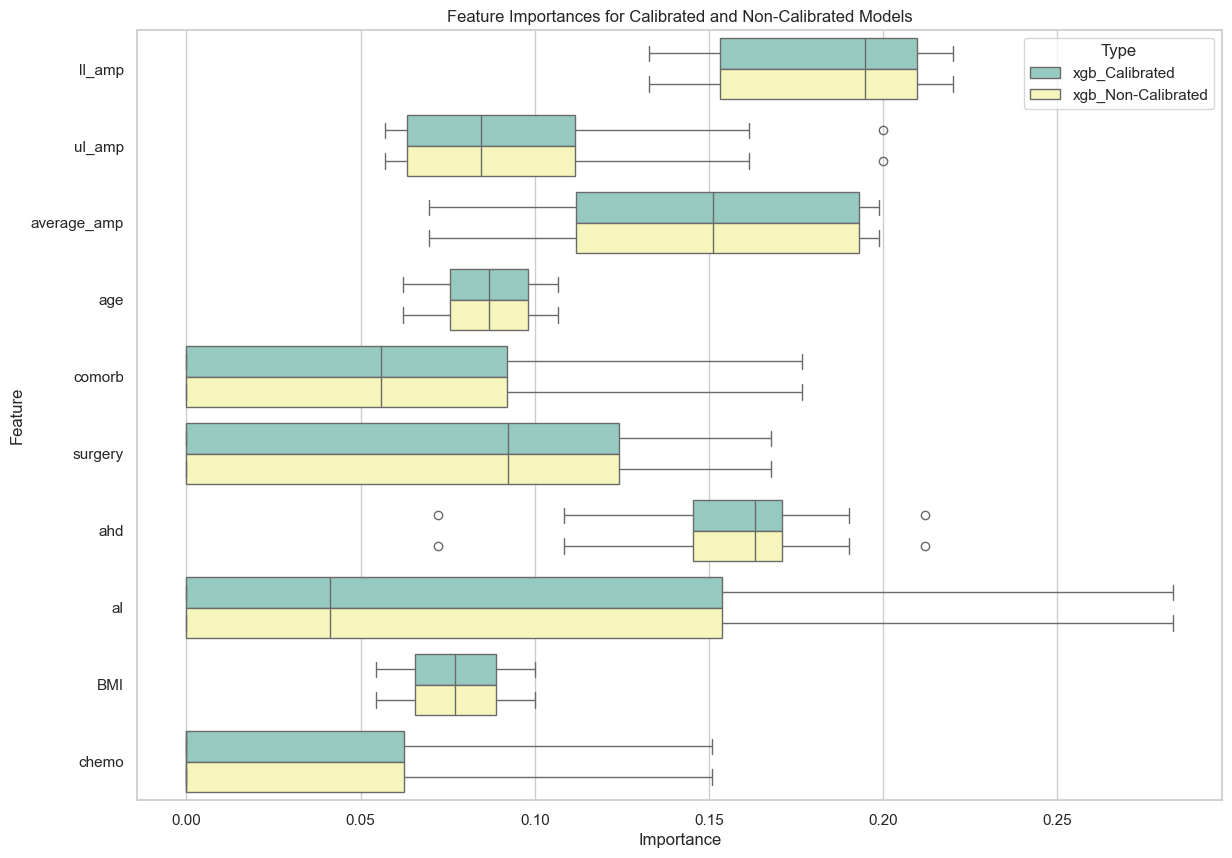

In [12]:
# Box plot
plt.figure(figsize=(14, 10))
sns.boxplot(x='Importance', y='Feature', hue='Type', data=df_importances, palette='Set3')
plt.title('Feature Importances for Calibrated and Non-Calibrated Models')
plt.show()

## Store the results for models into a csv file

In [13]:
loaded_results = joblib.load('results/bs_training_data/python_objects/results_xgb.joblib')
calibrated_summary, non_calibrated_summary = bs_results.get_results(loaded_results)

Calibrated Model Metrics Summary
              accuracy  precision    recall  f1_score   roc_auc
mean          0.746344   0.807277  0.693719  0.738348  0.810990
std           0.022171   0.057543  0.099371  0.040191  0.016427
min           0.688525   0.666667  0.437500  0.595745  0.755927
max           0.819672   0.950000  0.937500  0.835821  0.870690
95% CI lower  0.702889   0.694493  0.498952  0.659574  0.778793
95% CI upper  0.789800   0.920060  0.888485  0.817122  0.843187

Non-Calibrated Model Metrics Summary
              accuracy  precision    recall  f1_score   roc_auc
mean          0.745984   0.807599  0.692406  0.737688  0.769209
std           0.022127   0.057596  0.099513  0.040337  0.017647
min           0.688525   0.666667  0.437500  0.595745  0.707435
max           0.803279   0.950000  0.937500  0.828571  0.832435
95% CI lower  0.702615   0.694710  0.497361  0.658627  0.734621
95% CI upper  0.789352   0.920488  0.887452  0.816749  0.803797


In [14]:
filename='results/bs_training_data/csv/final_results.csv'
model_name = 'XGB'
bs_results.save_results_to_csv(calibrated_summary, non_calibrated_summary, filename=filename, model_name=model_name)

'Data saved to results/bs_training_data/csv/final_results.csv'

# Model Building without Bootstraping

In [ ]:
non_bs_model, results_calibrated, results_non_calibrated = bs_calibrate.get_calibrated_model(X_t, y_t, X_v, y_v, preprocessor, 
                                                          xgb.XGBClassifier, best_params=best_params,
                                                         model_name_prefix="xgb", csv_filename="results/non_bs_training_data/csv/model_metrics.csv")


In [ ]:
results_calibrated['Brier Score'], results_non_calibrated['Brier Score']

## Saving the data

In [ ]:
joblib.dump(non_bs_model, 'results/non_bs_training_data/models/non_bs_model_xgb.joblib')
joblib.dump(results_calibrated, 'results/non_bs_training_data/python_objects/results_calibrated_xgb.joblib')
joblib.dump(results_non_calibrated, 'results/non_bs_training_data/python_objects/results_non_calibrated_xgb.joblib')

In [ ]:
custom_voting_classifier = utils.CustomVotingClassifier(models=top_models_xgb, voting='soft')

In [ ]:
custom_voting_classifier.predict(X_int_val)